In [37]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.phasediagram.analyzer import PDAnalyzer
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import sys

In [38]:
def get_chempots_phases_enthalpies(chsys, formula, elem):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition
    
    entries = [e for e in entries if e.name not in exclusion_list]
    comp_entry = Composition(formula)
    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    evolution_profile = pda.get_element_profile(Element(elem), comp_entry)
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
        compound = PDEntry(Composition(formula), 0)
        e0 = pda.get_e_above_hull(compound)
        compound = PDEntry(Composition(formula), -(e0/comp_entry.num_atoms))
    else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
            #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
        mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
        compound = mpentry[0]
    
    reac = [compound]
    reac.append(evolution_profile[0]['element_reference'])
    
    for stage in evolution_profile:
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(compound.name))
        enthalpies.append(rxn.calculated_reaction_energy)
        reactions.append(str(rxn))
        if abs(stage['evolution']) < 0.0001: #the compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    if not window: #if there is no stability window, check if it is metastable
        ehull = pda.get_e_above_hull(compound)
        if ehull > 0: #the compound is metastable
            yshift = -(ehull*comp_entry.num_atoms) #set y-shift to the e above hull for the formula unit
            
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift
        yvec.append(ynew)            
    
    return [chempots, phases, yvec, enthalpies, reactions, formula]

In [102]:
def extrapolate_enthalpy(chempots, yvec, target):
    i = 0
    for c in chempots:
        if c < target:
            i = chempots.index(c)
    
    m = (yvec[i]-yvec[i-1])/(chempots[i]-chempots[i-1])
    b = m*chempots[i] + yvec[i]
    enthalpy = m*target - b
    
    return enthalpy

In [39]:
%matplotlib inline

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 14
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

import pandas as pnds

In [72]:
S = get_chempots_phases_enthalpies(['S','O'],'S','O')
Li = get_chempots_phases_enthalpies(['Li','O'],'Li','O')
LCO = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O')

In [75]:
pnds.options.display.float_format = '{:.3f}'.format

table1 = pnds.DataFrame({r'$\mu_O$ (eV)':S[0],
                      'Phase Equilibria':S[1],
                     r'$\Delta H$ per S (eV/atom)':S[3],
                        'Reaction':S[4]})

table2 = pnds.DataFrame({r'$\mu_O$ (eV)':Li[0],
                      'Phase Equilibria':Li[1],
                     r'Rxn Energy (eV/atom)':Li[3],
                        'Reaction':Li[4]})

table3 = pnds.DataFrame({r'$\mu_O$ (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                     r'Rxn Energy (eV/atom)':LCO[3],
                        'Reaction':LCO[4]})
table3 = table3[['Reaction','Phase Equilibria',r'$\mu_O$ (eV)',r'Rxn Energy (eV/atom)']]

display(table1)
display(table2)
display(table3)

,$\Delta H$ per S (eV/atom),$\mu_O$ (eV),Phase Equilibria,Reaction
0,-7.044,0.000,[SO3],S + 1.5 O2 -> SO3
1,-5.273,-1.771,[SO2],S + O2 -> SO2
2,0.000,-2.636,[S],S -> S


,$\mu_O$ (eV),Phase Equilibria,Reaction,Rxn Energy (eV/atom)
0,0.000,[Li2O2],0.5 O2 + Li -> 0.5 Li2O2,-3.300
1,-0.387,[Li2O],0.25 O2 + Li -> 0.5 Li2O,-3.106
2,-6.213,[Li],Li -> Li,0.000


,Reaction,Phase Equilibria,$\mu_O$ (eV),Rxn Energy (eV/atom)
0,0.1111 O2 + LiCoO2 -> 0.2222 Li(CoO2)2 + 0.1111 Li7Co5O12,"[Li7Co5O12, Li(CoO2)2]",0.000,-0.084
1,LiCoO2 -> LiCoO2,[LiCoO2],-0.378,-0.000
2,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",-2.644,1.322
3,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Co, Li6CoO4]",-2.660,3.539
4,LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O,"[Li2O, Co]",-2.903,4.023
5,LiCoO2 -> O2 + Li + Co,"[Co, Li]",-6.213,7.129


LCO begins to evolve oxygen at a chemical potential of -2.644 eV. So for pseudo-binaries with an LCO electrolyte, when looking at the oxygen evolution, we can narrow down the window of interest by throwing out all chemical potentials above the stability of LCO. Therefore when looking at pseudo-binaries we should only consider chemical potentials beyond -2.644 eV and below.

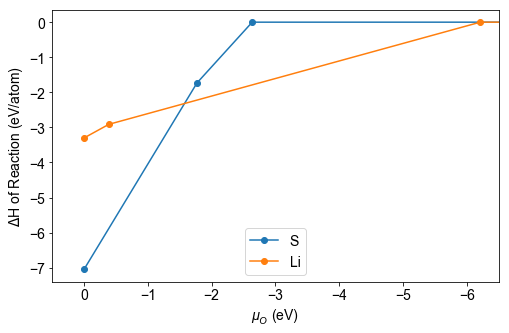

In [42]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((S_cpe[0] + [-10]), (S_cpe[2] + [S_cpe[2][-1]]), 'o', ls='-', label= r'S')
p2 = plt.plot(Li_cpe[0] + [-10], Li_cpe[2] + [S_cpe[2][-1]], 'o', ls='-', label= r'Li')

plt.xlim(-6.5, 0.5)
ax.invert_xaxis()
legend = ax.legend(loc='lower center')
plt.show()

Oxygen chemical potential of 0 indicates atmospheric conditions. Without the effects of kinetics, we can assume that the reaction that occurs at a chemical potential of 0 is the reaction favored to occur in atmospheric conditions (and the heat released will be related to the change in enthalpy of the reaction).

In [43]:
LPS = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')

In [129]:
table1 = pnds.DataFrame({r'$\mu_O$ (eV)':LPS[0],
                      'Phase Equilibria':LPS[1],
                     r'$\Delta H_{rxn}$':LPS[3],
                        'Reaction':LPS[4]})
pnds.set_option('max_colwidth', 100)
display(table1)

,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-42.358,0.000,"[P2O5, Li2S2O7, SO3]",8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5
1,-40.587,-1.771,"[SO2, Li2S2O7, P2O5]",7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5
2,-38.575,-2.012,"[SO2, Li2S2O7, LiPO3]",7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7
3,-36.234,-2.341,"[SO2, Li2SO4, LiPO3]",6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4
4,-18.722,-2.594,"[LiPO3, P2S7, Li2SO4]",3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4 + 0.375 P2S7
5,-17.739,-2.722,"[Li2SO4, Li4P2O7, P2S7]",2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li2SO4 + 0.3889 P2S7
6,-16.928,-2.807,"[Li3PO4, P2S7, Li2SO4]",2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7
7,0.000,-3.023,[Li3PS4],Li3PS4 -> Li3PS4


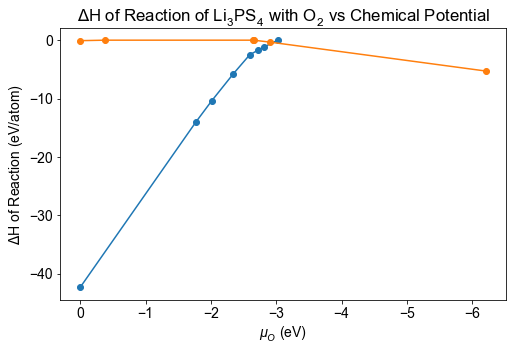

In [128]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS[0]), (LPS[2]), 'o', ls='-', label= r'lps')
p2 = plt.plot((LCO[0]), (LCO[2]), 'o', ls='-', label= r'lco')
# legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

In [103]:
extrapolate_enthalpy(LPS[0], LPS[2], -2.644)

-2.1218888245000027

In [46]:
LiF = get_chempots_phases_enthalpies(['Li','F','O'],'LiF','O')
Li2O = get_chempots_phases_enthalpies(['Li','O'],'Li2O','O')
Li2S = get_chempots_phases_enthalpies(['Li','S','O'],'Li2S','O')
Li3N = get_chempots_phases_enthalpies(['Li','N','O'],'Li3N','O')

In [47]:
LGPS = get_chempots_phases_enthalpies(['Li','Ge','P','S','O'],'Li10GeP2S12','O')
LLZO = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O')
LATP = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Ti173Al3P30O120','O')

In [48]:
for var in [LiF, Li2O, Li2S, Li3N, LGPS, LLZO, LATP]:
    print var[5]
    table = pnds.DataFrame({r'$\mu_O$ (eV)':var[0],
                      'Phase Equilibria':var[1],
                     r'$\Delta H_{rxn}$':var[3],
                        'Reaction':var[4]})
    display(table)

LiF


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,0.000,0.000,[LiF],LiF -> LiF


Li2O


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-0.387,0.000,[Li2O2],0.5 O2 + Li2O -> Li2O2
1,-0.000,-0.387,[Li2O],Li2O -> Li2O
2,6.213,-6.213,[Li],Li2O -> 0.5 O2 + 2 Li


Li2S


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-12.266,0.000,[Li2SO4],2 O2 + Li2S -> Li2SO4
1,0.000,-3.066,[Li2S],Li2S -> Li2S


Li3N


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-12.131,0.000,"[Li2O2, LiNO3]",2.5 O2 + Li3N -> LiNO3 + Li2O2
1,-11.743,-0.387,"[Li2O, LiNO3]",2 O2 + Li3N -> LiNO3 + Li2O
2,-7.479,-1.706,"[Li2O, N2]",0.75 O2 + Li3N -> 1.5 Li2O + 0.5 N2
3,-7.000,-2.877,"[Li2O, LiN3]",0.6667 O2 + Li3N -> 0.3333 LiN3 + 1.333 Li2O
4,0.000,-5.250,[Li3N],Li3N -> Li3N


Li10GeP2S12


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-129.869,0.000,"[GeP2O7, Li2S2O7, SO3]",24 O2 + Li10Ge(PS6)2 -> 2 SO3 + 5 Li2S2O7 + GeP2O7
1,-126.327,-1.771,"[GeP2O7, SO2, Li2S2O7]",23 O2 + Li10Ge(PS6)2 -> 2 SO2 + 5 Li2S2O7 + GeP2O7
2,-114.623,-2.341,"[GeP2O7, SO2, Li2SO4]",20.5 O2 + Li10Ge(PS6)2 -> 7 SO2 + 5 Li2SO4 + GeP2O7
3,-96.935,-2.527,"[LiPO3, GeS2, SO2, Li2SO4]",17 O2 + Li10Ge(PS6)2 -> GeS2 + 6 SO2 + 2 LiPO3 + 4 Li2SO4
4,-61.911,-2.594,"[LiPO3, Li2SO4, P2S7, GeS2]",10.25 O2 + Li10Ge(PS6)2 -> GeS2 + 0.5 LiPO3 + 4.75 Li2SO4 + 0.75 P2S7
5,-59.945,-2.722,"[GeS2, Li4P2O7, P2S7, Li2SO4]",9.889 O2 + Li10Ge(PS6)2 -> GeS2 + 0.2222 Li4P2O7 + 4.556 Li2SO4 + 0.7778 P2S7
6,-58.323,-2.807,"[Li3PO4, Li2SO4, P2S7, GeS2]",9.6 O2 + Li10Ge(PS6)2 -> GeS2 + 0.4 Li3PO4 + 4.4 Li2SO4 + 0.8 P2S7
7,-34.336,-2.998,"[Li3PO4, Li2SO4, P2S7, Li4GeS4]",5.6 O2 + Li10Ge(PS6)2 -> Li4GeS4 + 0.4 Li3PO4 + 2.4 Li2SO4 + 0.8 P2S7
8,-0.479,-3.023,"[Li4GeS4, Li3PS4]",Li10Ge(PS6)2 -> 2 Li3PS4 + Li4GeS4


Li7La3Zr2O12


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-0.745,0.000,"[La2Zr2O7, Li2O2, La2O3]",1.75 O2 + Li7La3Zr2O12 -> La2Zr2O7 + 3.5 Li2O2 + 0.5 La2O3
1,-0.368,-0.126,"[La2O3, Li6Zr2O7, Li2O2]",0.25 O2 + Li7La3Zr2O12 -> 0.5 Li2O2 + 1.5 La2O3 + Li6Zr2O7
2,-0.175,-0.387,"[La2O3, Li6Zr2O7, Li2O]",Li7La3Zr2O12 -> 0.5 Li2O + 1.5 La2O3 + Li6Zr2O7
3,20.215,-6.117,"[Zr3O, Li2O, La2O3]",Li7La3Zr2O12 -> 1.667 O2 + 0.6667 Zr3O + 1.5 La2O3 + 3.5 Li2O
4,24.351,-6.204,"[La2O3, Li2O, Zr]",Li7La3Zr2O12 -> 2 O2 + 2 Zr + 1.5 La2O3 + 3.5 Li2O
5,46.095,-6.213,"[La2O3, Li, Zr]",Li7La3Zr2O12 -> 3.75 O2 + 2 Zr + 1.5 La2O3 + 7 Li
6,75.305,-6.491,"[Zr, Li, La]",Li7La3Zr2O12 -> 6 O2 + 2 Zr + 3 La + 7 Li


Li13Ti173Al3P30O120


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-4357.971,0.000,"[LiTiPO5, TiO2, LiTi2(PO4)3, AlPO4]",156 O2 + Li13Ti173Al3(PO4)30 -> 6 LiTiPO5 + 7 LiTi2(PO4)3 + 3 AlPO4 + 153 TiO2
1,-4220.759,-3.920,"[LiTiPO5, AlPO4, P, TiO2]",138.5 O2 + Li13Ti173Al3(PO4)30 -> 13 LiTiPO5 + 3 AlPO4 + 160 TiO2 + 14 P
2,-4135.355,-3.942,"[Li3PO4, AlPO4, P, TiO2]",127.7 O2 + Li13Ti173Al3(PO4)30 -> 4.333 Li3PO4 + 3 AlPO4 + 173 TiO2 + 22.67 P
3,-4043.605,-4.048,"[Li3PO4, TiO2, AlPO4, TiP2]",116.3 O2 + Li13Ti173Al3(PO4)30 -> 4.333 Li3PO4 + 3 AlPO4 + 11.33 TiP2 + 161.7 TiO2
4,-3998.009,-4.071,"[Li3PO4, TiP2, LiAl5O8, TiO2]",110.7 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 4.133 Li3PO4 + 12.93 TiP2 + 160.1 TiO2
5,-3891.028,-4.136,"[Li3PO4, TiP, LiAl5O8, TiO2]",97.8 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 4.133 Li3PO4 + 25.87 TiP + 147.1 TiO2
6,-3786.930,-4.198,"[LiTi2O4, TiP, LiAl5O8, TiO2]",85.4 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 12.4 LiTi2O4 + 30 TiP + 118.2 TiO2
7,-3610.325,-4.482,"[LiTi2O4, Ti3O5, LiAl5O8, TiP]",65.7 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 12.4 LiTi2O4 + 30 TiP + 39.4 Ti3O5
8,-3519.872,-4.592,"[LiTi2O4, Ti2O3, LiAl5O8, TiP]",55.85 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 12.4 LiTi2O4 + 30 TiP + 59.1 Ti2O3
9,-3446.500,-4.891,"[Ti4P3, Ti2O3, LiAl5O8, LiTi2O4]",48.35 O2 + Li13Ti173Al3(PO4)30 -> 0.6 LiAl5O8 + 12.4 LiTi2O4 + 10 Ti4P3 + 54.1 Ti2O3


In [79]:
def get_mix_stability(m_id1, m_id2, chemsys, elem, ratio):
    '''m_id1 and m_id2 are Materials Project material identifier strings, chemsys is a list of strings of all the 
    elements in the system, and elem is the reference element. '''
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chemsys)
        m1 = m.get_entry_by_material_id(m_id1)
        m2 = m.get_entry_by_material_id(m_id2)

    m1C = Composition(m1.name)
    m2C = Composition(m2.name)

    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    
    x = ratio
    E0 = m1.energy_per_atom * x + m2.energy_per_atom * (1 - x)
    comp = (1/m1C.num_atoms) * x * m1C + (1/m2C.num_atoms) * (1 - x) * m2C
    
    evolution_profile = pda.get_element_profile(Element(elem), comp)
    ref = evolution_profile[0]['element_reference']

    reac = [PDEntry(comp, E0)]
    reac.append(ref)
    
    chempots = []
    evolutions = []
    phases = []
    enthalpies = []
    yvec = []
    reactions = []
    
    for stage in evolution_profile:
        chempots.append((stage['chempot'] - ref.energy_per_atom))
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(comp))
        reactions.append(str(rxn))
        enthalpies.append(rxn.calculated_reaction_energy) 
        if abs(stage['evolution']) < 0.0001: #find y-axis shift (force all compounds to be stable)
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*chempots[i] + enthalpies[i]) - yshift
        yvec.append(ynew)            
    
    return [chempots, phases, yvec, enthalpies, reactions]

In [125]:
LPS_LCO = get_mix_stability('mp-985583', 'mp-24850', ['Li','P','S','Co','O'], 'O', 0.5)

In [126]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
listylist = []
for r in LPS_LCO[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

table4 = pnds.DataFrame({r'$\mu_O$ (eV)':LPS_LCO[0],
                      'Phase Equilibria':LPS_LCO[1],
                     r'$\Delta H_{rxn}$':LPS_LCO[3],
                        'Reaction':listylist})

table5 = pnds.DataFrame({r'$\mu_O$ (eV)':LPS_LCO[0][8:],
                      'Phase Equilibria':LPS_LCO[1][8:],
                     r'$\Delta H_{rxn}$':LPS_LCO[3][8:],
                        'Reaction':listylist[8:]})
display(table4)
display(table5)

pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-2.871,0.000,"[CoPO4, CoSO4, Li2SO4, Li2S2O7]",0.4844 O2 + LPS-LCO -> 0.125 Li2SO4 + 0.03125 Li2S2O7 + 0.0625 CoPO4 + 0.0625 CoSO4
1,-2.867,-0.205,"[CoPO4, CoSO4, Li2SO4, Co(PO3)3]",0.4766 O2 + LPS-LCO -> 0.1563 Li2SO4 + 0.01563 CoPO4 + 0.09375 CoSO4 + 0.01562 Co(PO3)3
2,-2.867,-0.231,"[CoPO4, CoSO4, Li2SO4, LiCo(PO3)4]",0.475 O2 + LPS-LCO -> 0.15 Li2SO4 + 0.0125 CoPO4 + 0.1 CoSO4 + 0.0125 LiCo(PO3)4
3,-2.862,-0.403,"[CoSO4, Li2SO4, Co(PO3)2]",0.4687 O2 + LPS-LCO -> 0.1563 Li2SO4 + 0.03125 Co(PO3)2 + 0.09375 CoSO4
4,-2.073,-2.403,"[Co(PO3)2, Co3(PO4)2, Li2SO4, CoS2]",0.3047 O2 + LPS-LCO -> 0.04687 CoS2 + 0.007813 Co(PO3)2 + 0.1562 Li2SO4 + 0.02344 Co3(PO4)2
5,-1.807,-2.435,"[LiCoPO4, Li2SO4, CoS2]",0.25 O2 + LPS-LCO -> 0.0625 CoS2 + 0.125 Li2SO4 + 0.0625 LiCoPO4
6,-1.728,-2.507,"[LiCoPO4, Li2SO4, LiPO3, Co3S4]",0.2344 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.03125 LiPO3 + 0.125 Li2SO4 + 0.03125 LiCoPO4
7,-1.492,-2.520,"[LiCoPO4, Li4P2O7, Li2SO4, Co3S4]",0.1875 O2 + LPS-LCO -> 0.0375 Co3S4 + 0.025 Li4P2O7 + 0.1 Li2SO4 + 0.0125 LiCoPO4
8,-1.332,-2.561,"[Co3S4, Li3PO4, Li2SO4, Li4P2O7]",0.1562 O2 + LPS-LCO -> 0.08333 Li2SO4 + 0.02083 Li3PO4 + 0.04167 Co3S4 + 0.02083 Li4P2O7
9,-1.169,-2.605,"[Co3S4, Li3PO4, Li2SO4, CoS2]",0.125 O2 + LPS-LCO -> 0.0625 Li2SO4 + 0.03125 CoS2 + 0.0625 Li3PO4 + 0.03125 Co3S4


,$\Delta H_{rxn}$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-1.332,-2.561,"[Co3S4, Li3PO4, Li2SO4, Li4P2O7]",0.1562 O2 + LPS-LCO -> 0.08333 Li2SO4 + 0.02083 Li3PO4 + 0.04167 Co3S4 + 0.02083 Li4P2O7
1,-1.169,-2.605,"[Co3S4, Li3PO4, Li2SO4, CoS2]",0.125 O2 + LPS-LCO -> 0.0625 Li2SO4 + 0.03125 CoS2 + 0.0625 Li3PO4 + 0.03125 Co3S4
2,-0.403,-3.066,"[Co3S4, Li3PO4, CoS2, Li2S]",LPS-LCO -> 0.0625 Li2S + 0.03125 CoS2 + 0.0625 Li3PO4 + 0.03125 Co3S4
3,-0.325,-3.715,"[Co3S4, Li3PO4, Li2S, Li3PS4]",LPS-LCO -> 0.01042 O2 + 0.0625 Li2S + 0.05729 Li3PO4 + 0.04167 Co3S4 + 0.005208 Li3PS4
4,-0.110,-3.877,"[Li3PS4, Li3PO4, Li2S, Co9S8]",LPS-LCO -> 0.03819 O2 + 0.01389 Co9S8 + 0.0191 Li3PS4 + 0.0625 Li2S + 0.0434 Li3PO4
5,0.588,-4.017,"[Li3PS4, Li2S, CoP, Co9S8]",LPS-LCO -> 0.125 O2 + 0.008197 Co9S8 + 0.01127 Li3PS4 + 0.1393 Li2S + 0.05123 CoP


$\Delta$H is normalized to the active material in the reaction, so in this case, the pseudo-binary of LPS and LCO (50-50 ratio). The formula for this pseudo-binary is Li0.3125Co0.125P0.0625S0.25O0.25. In the reactions displayed here, this long formula has been replaced by the abbreviation "LPS-LCO". Also, reactions with $\mu_O$ above the stability of LCO are removed in the second table to reduce clutter.

We see from the table that LPS-LCO begins to evolve oxygen at a chemical potential of -3.715 eV (already lower than the O2 stability of LCO).

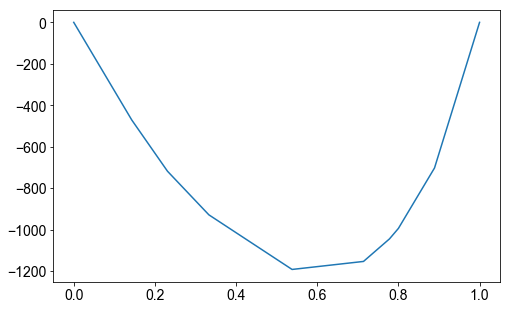

In [108]:
frac_lco = [1, 0.889, 0.8, 0.778, 0.714, 0.538, 0.333, 0.231, 0.143, 0.0]
mutual_rxn_e = [0.0, -702.1, -993.6, -1044.1, -1152.8, -1191.4, -928.1, -717.8, -470.8, 0.0]

p = plt.plot(frac_lco, mutual_rxn_e)
plt.show()